In [1]:
import os, glob, pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

2025-05-29 16:57:04.717046: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-29 16:57:04.907332: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-29 16:57:04.907417: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-29 16:57:04.937813: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-29 16:57:05.007078: I tensorflow/core/platform/cpu_feature_guar

In [2]:
MODEL_PATH   = "./modelo_20250529_1655_testAcc0.81.256.h5"
IMG_SIZE     = (256, 256)                        
CLASS_NAMES  = [                                 #
    "argentine-ants",
    "black-crazy-ants",
    "fire-ants",
    "leafcutter-ants",
    "trap-jaw-ants",
    "weaver-ants",
    "yellow-crazy-ants"
]

In [3]:
NUM_CLASSES  = len(CLASS_NAMES)
TEST_DIR     = pathlib.Path("test_images")

In [4]:
model = tf.keras.models.load_model(MODEL_PATH)
model.summary()
inner_layers = model.layers[0].layers   # capas dentro del 'sequential'
print(len(inner_layers), "sub-capas en el Sequential interno")
print("Primer sub-capa:", inner_layers[0].name, inner_layers[0].__class__.__name__)

2025-05-29 16:57:08.626083: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-29 16:57:08.698588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-29 16:57:08.698633: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-29 16:57:08.700587: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-29 16:57:08.700627: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 8, 8, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 6249047 (23.84 MB)
Trainable params: 61884

In [5]:
def load_preprocess(path: pathlib.Path) -> np.ndarray:
    """
    Returns float32 tensor in range [0,1] shaped (H,W,3)
    """
    img = Image.open(path).convert("RGB").resize(IMG_SIZE)
    arr = np.asarray(img, dtype=np.float32) / 255.0   # same rescale used in training
    return arr

In [6]:
# Cargar rutas Y SALTAR archivos no‑imagen
valid_ext = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}

image_paths, images, file_names = [], [], []

for p in TEST_DIR.rglob("*"):
    # descarta alternate streams o archivos sin extensión conocida
    if p.suffix.lower() not in valid_ext or not p.is_file():
        continue
    try:
        img = load_preprocess(p)      # intenta abrir y normalizar
        images.append(img)
        image_paths.append(p)
        file_names.append(p.name)
    except Exception as e:
        print(f"⚠️  Skipping {p.name}: {e}")

if not images:
    raise RuntimeError("No valid images were loaded.")

images = np.stack(images)
print(images.min(), images.max()) 
print(f"Loaded {len(images)} images.")

0.0 1.0
Loaded 25 images.


In [7]:
preds = model.predict(images, batch_size=32, verbose=1)
print("Salidas del modelo:", preds.shape)
print("Longitud CLASS_NAMES:", len(CLASS_NAMES))


2025-05-29 16:57:24.488564: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


1/1 [==============================] - 6s 6s/step
Salidas del modelo: (25, 7)
Longitud CLASS_NAMES: 7


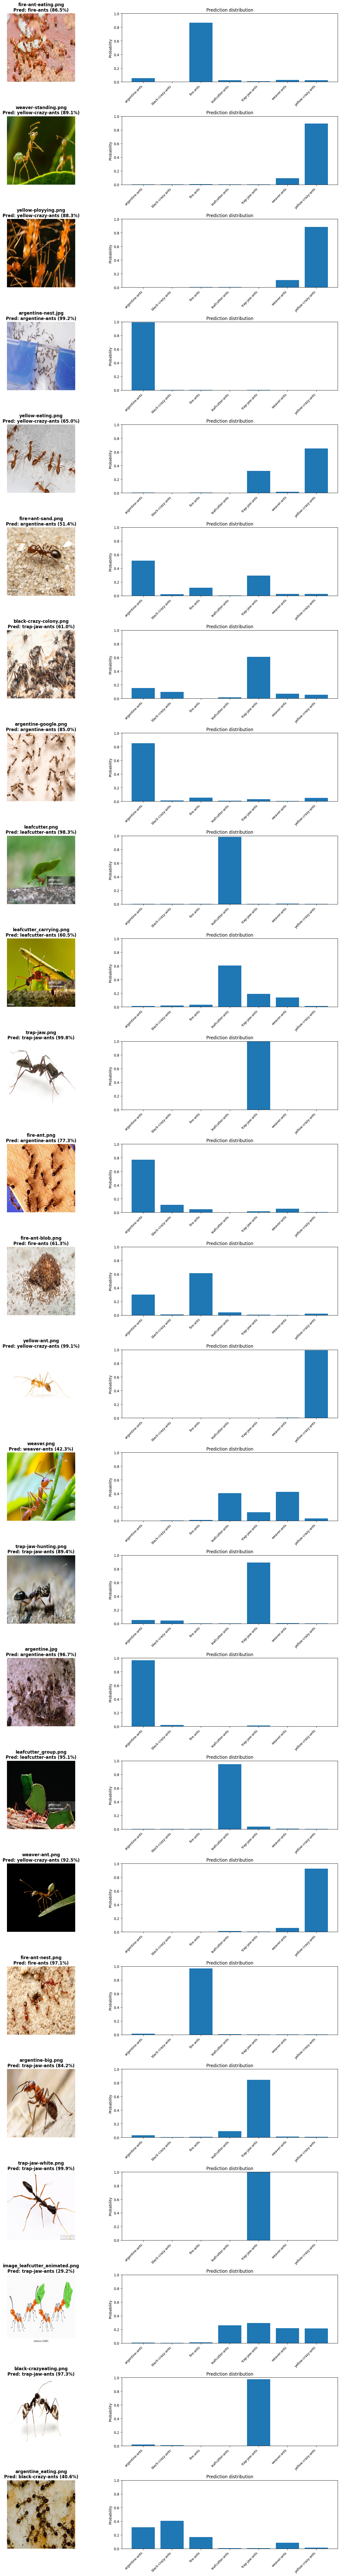

In [8]:
import math
import matplotlib.pyplot as plt
import numpy as np

ROWS = len(images)
if ROWS == 0:
    raise RuntimeError("No hay imágenes cargadas – nada que graficar.")

rows_to_plot = ROWS
    
fig, axes = plt.subplots(
    rows_to_plot, 2,
    figsize=(16, 4 * rows_to_plot),
    squeeze=False 
)
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i in range(rows_to_plot):
    img        = images[i]
    pred_vec   = preds[i]
    fname      = file_names[i]
    
    pred_idx   = np.argmax(pred_vec)
    pred_lbl   = CLASS_NAMES[pred_idx]
    confidence = pred_vec[pred_idx]

    ax_img = axes[i, 0]
    ax_img.imshow((img * 255).astype("uint8"))
    ax_img.axis("off")
    ax_img.set_title(
        f"{fname}\nPred: {pred_lbl} ({confidence:.1%})",
        fontweight="bold",
        fontsize=12
    )

    ax_bar = axes[i, 1]
    ax_bar.bar(range(NUM_CLASSES), pred_vec, color="tab:blue")
    ax_bar.set_xticks(range(NUM_CLASSES))
    ax_bar.set_xticklabels(CLASS_NAMES, rotation=45, ha="right", fontsize=9)
    ax_bar.set_ylim(0, 1)
    ax_bar.set_ylabel("Probability")
    ax_bar.set_title("Prediction distribution")

plt.tight_layout()
plt.show()
